In [48]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import matplotlib

matplotlib.rcParams["text.usetex"] = True
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
runs_path = Path("../runs/ppo")
run_basename = "final_stairs_from_scratch_thesis_"
all_runs = list(runs_path.glob(f"{run_basename}*"))
all_runs.sort()
print(all_runs)
best_run_seed = 42

[PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_13_2025-05-09_23-16-35'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_16_2025-05-09_23-16-51'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_26_2025-05-09_23-16-32'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_32_2025-05-09_23-16-48'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_420_2025-05-09_23-16-39'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_42_2025-05-09_23-17-08'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_64_2025-05-09_23-16-44'), PosixPath('../runs/ppo/final_stairs_from_scratch_thesis_98_2025-05-09_23-16-16')]


In [58]:
train_frames, eval_frames = [], []
best_train, best_eval = None, None
for run in all_runs:
    train_csv = run / "train.csv"
    eval_csv = run / "eval.csv"
    if not train_csv.exists() or not eval_csv.exists():
        print(f"Missing {train_csv} or {eval_csv}")
        continue
    train_df = pd.read_csv(train_csv)
    eval_df = pd.read_csv(eval_csv)
    train_frames.append(train_df)
    eval_frames.append(eval_df)
    if f"{run_basename}{best_run_seed}" in run.name:
        best_train = train_df
        best_eval = eval_df

# concatenate all dataframes along index
train_df = pd.concat(train_frames)
eval_df = pd.concat(eval_frames)
mean_train_df = train_df.groupby(train_df.index).mean()
std_train_df = train_df.groupby(train_df.index).std()
mean_eval_df = eval_df.groupby(eval_df.index).mean()
std_eval_df = eval_df.groupby(eval_df.index).std()

In [59]:
train_df.keys(), eval_df.keys()

(Index(['collected_frames', 'train/mean_action_sample_log_prob',
        'train/mean_critic_loss', 'train/mean_objective_loss',
        'train/mean_entropy_loss', 'train/mean_entropy', 'train/mean_kl_approx',
        'train/mean_clip_fraction', 'train/mean_advantage',
        'train/std_advantage', 'train/total_grad_norm',
        'train/policy_operator_lr', 'train/value_operator_lr'],
       dtype='object'),
 Index(['collected_frames', 'eval/mean_step_reward', 'eval/max_step_reward',
        'eval/min_step_reward', 'eval/mean_step_count', 'eval/max_step_count',
        'eval/min_step_count', 'eval/pct_succeeded', 'eval/pct_failed',
        'eval/pct_truncated'],
       dtype='object'))

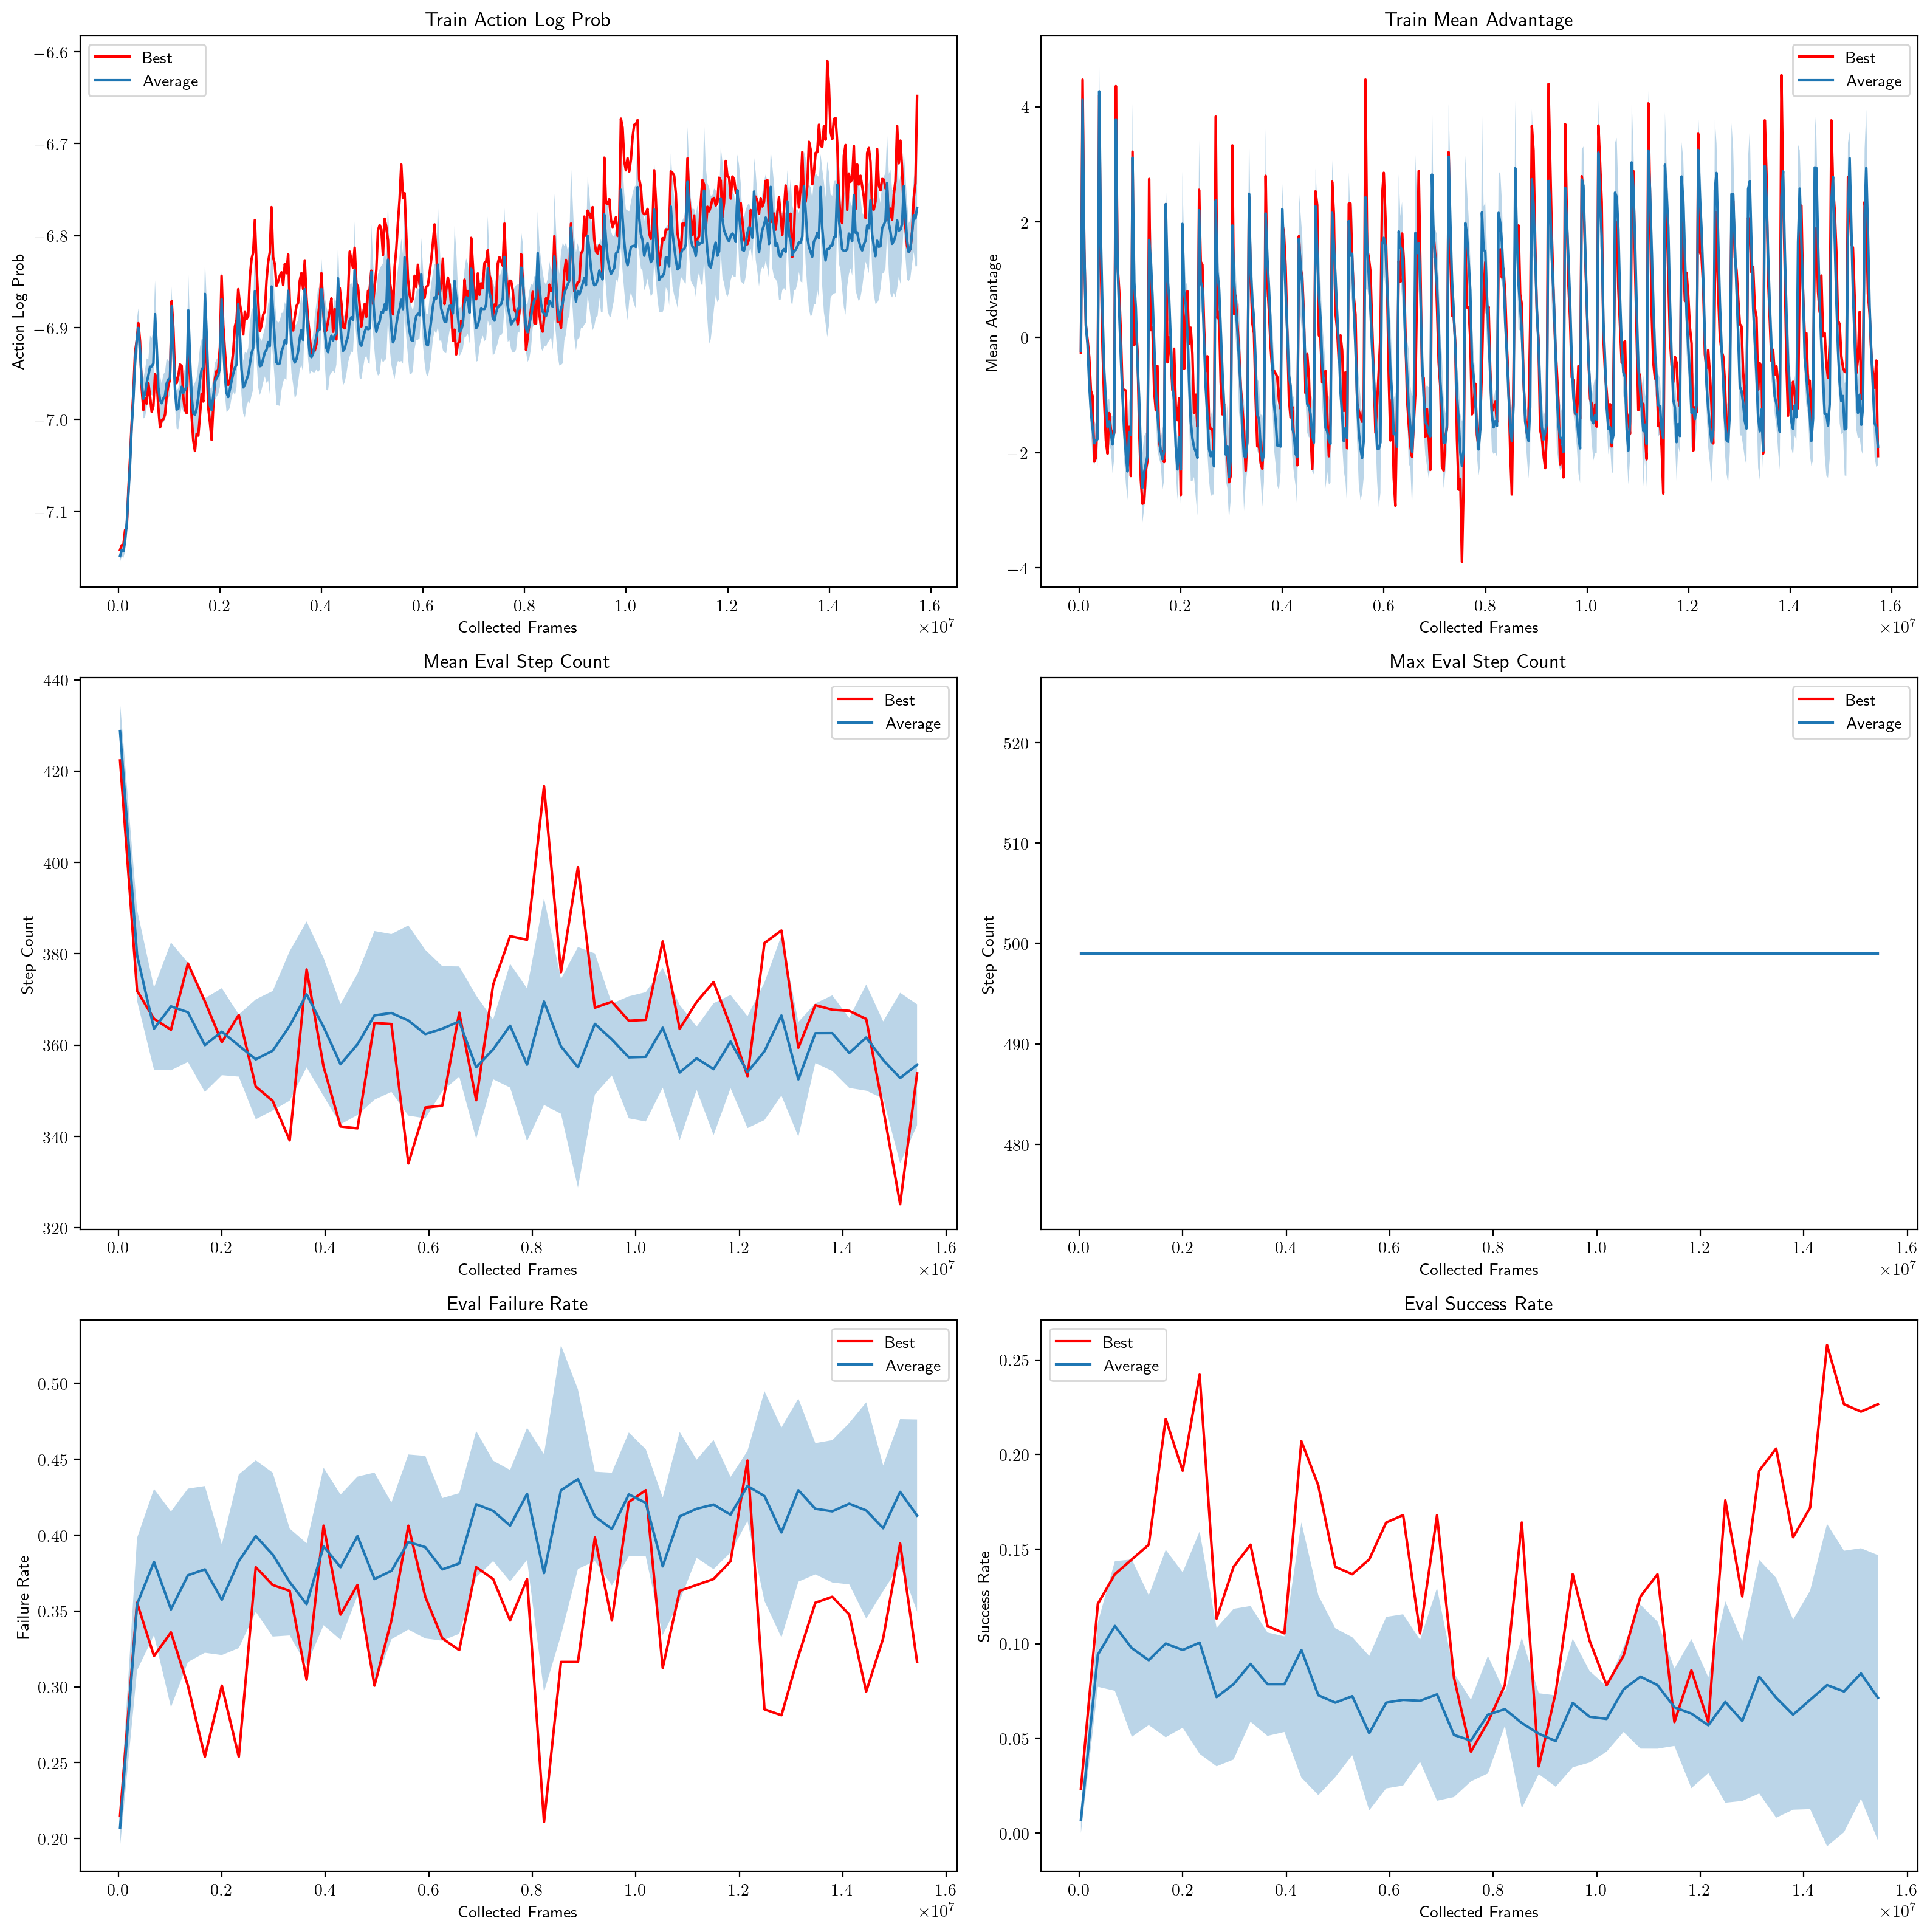

In [60]:
# we want to show eval mean episode length, failure rate, and success rate
# for train we want the action log prob, mean advantage and mean kl divergence
fig, ax = plt.subplots(3, 2, figsize=(16, 16), dpi=200)
# row0: train metrics; row1: step count; row2: fail/success
# best run
ax[0, 0].plot(best_train["collected_frames"], best_train["train/mean_action_sample_log_prob"], label="Best", color="red")
ax[0, 1].plot(best_train["collected_frames"], best_train["train/mean_advantage"], label="Best", color="red")
ax[1, 0].plot(best_eval["collected_frames"], best_eval["eval/mean_step_count"], label="Best", color="red")
ax[1, 1].plot(best_eval["collected_frames"], best_eval["eval/max_step_count"], label="Best", color="red")
ax[2, 0].plot(best_eval["collected_frames"], best_eval["eval/pct_failed"], label="Best", color="red")
ax[2, 1].plot(best_eval["collected_frames"], best_eval["eval/pct_succeeded"], label="Best", color="red")
# plot train data
ax[0, 0].plot(mean_train_df["collected_frames"], mean_train_df["train/mean_action_sample_log_prob"], label="Average")
ax[0, 0].fill_between(
    mean_train_df["collected_frames"],
    mean_train_df["train/mean_action_sample_log_prob"] - std_train_df["train/mean_action_sample_log_prob"],
    mean_train_df["train/mean_action_sample_log_prob"] + std_train_df["train/mean_action_sample_log_prob"],
    alpha=0.3,
)
ax[0, 0].set_title("Train Action Log Prob")
ax[0, 0].set_xlabel("Collected Frames")
ax[0, 0].set_ylabel("Action Log Prob")
ax[0, 0].legend()
ax[0, 1].plot(mean_train_df["collected_frames"], mean_train_df["train/mean_advantage"], label="Average")
ax[0, 1].fill_between(
    mean_train_df["collected_frames"],
    mean_train_df["train/mean_advantage"] - std_train_df["train/mean_advantage"],
    mean_train_df["train/mean_advantage"] + std_train_df["train/mean_advantage"],
    alpha=0.3,
)
ax[0, 1].set_title("Train Mean Advantage")
ax[0, 1].set_xlabel("Collected Frames")
ax[0, 1].set_ylabel("Mean Advantage")
ax[0, 1].legend()
# plot eval step-count
ax[1, 0].plot(mean_eval_df["collected_frames"], mean_eval_df["eval/mean_step_count"], label="Average")
ax[1, 1].plot(mean_eval_df["collected_frames"], mean_eval_df["eval/max_step_count"], label="Average")
ax[1, 0].fill_between(
    mean_eval_df["collected_frames"],
    mean_eval_df["eval/mean_step_count"] - std_eval_df["eval/mean_step_count"],
    mean_eval_df["eval/mean_step_count"] + std_eval_df["eval/mean_step_count"],
    alpha=0.3,
)
ax[1, 1].fill_between(
    mean_eval_df["collected_frames"],
    mean_eval_df["eval/max_step_count"] - std_eval_df["eval/max_step_count"],
    mean_eval_df["eval/max_step_count"] + std_eval_df["eval/max_step_count"],
    alpha=0.3,
)
ax[1, 0].set_title("Mean Eval Step Count")
ax[1, 0].set_xlabel("Collected Frames")
ax[1, 0].set_ylabel("Step Count")
ax[1, 0].legend()
ax[1, 1].set_title("Max Eval Step Count")
ax[1, 1].set_xlabel("Collected Frames")
ax[1, 1].set_ylabel("Step Count")
ax[1, 1].legend()
# plot eval failure / success
ax[2, 0].plot(mean_eval_df["collected_frames"], mean_eval_df["eval/pct_failed"], label="Average")
ax[2, 0].fill_between(
    mean_eval_df["collected_frames"],
    mean_eval_df["eval/pct_failed"] - std_eval_df["eval/pct_failed"],
    mean_eval_df["eval/pct_failed"] + std_eval_df["eval/pct_failed"],
    alpha=0.3,
)
ax[2, 0].set_title("Eval Failure Rate")
ax[2, 0].set_xlabel("Collected Frames")
ax[2, 0].set_ylabel("Failure Rate")
ax[2, 0].legend()
ax[2, 1].plot(mean_eval_df["collected_frames"], mean_eval_df["eval/pct_succeeded"], label="Average")
ax[2, 1].fill_between(
    mean_eval_df["collected_frames"],
    mean_eval_df["eval/pct_succeeded"] - std_eval_df["eval/pct_succeeded"],
    mean_eval_df["eval/pct_succeeded"] + std_eval_df["eval/pct_succeeded"],
    alpha=0.3,
)
ax[2, 1].set_title("Eval Success Rate")
ax[2, 1].set_xlabel("Collected Frames")
ax[2, 1].set_ylabel("Success Rate")
ax[2, 1].legend()
plt.tight_layout()
plt.savefig(f"/Users/davidkorcak/Documents/ctu/bachelors/bachelor_thesis/figures/{run_basename}train_eval.pdf")